# **tSDRG Data Analysis**

### 1. **Before start plotting, please change the file path "my_metadata_file = ..." to your own metadata directory.**
### &emsp;*By defalt is for dropbox path.*
### 2. **Dim / Jdis = Dimerization / Randomness strength** 

### 3. **DimABC / JdisABC = Dimerization A.BC / Randomness strength A.BC**
### &emsp;*example: Dim123 = Dimerization 1.23*

# **Define metadata directory path**

In [8]:
## ------------------------------------------ Please change blow path to your own metadata directory path ------------------------------------------
# my_metadata_file = '../tSDRG_metadata/Spin1/metadata/' ## Your local path (not necessary)
my_metadata_file = '/mnt/c/Users/LiuSF/Dropbox/Proj_tSDRG/figs/Data and Plot python file/Spin1_metadata/Spin1/metadata/'
# my_metadata_file = './Spin2_metadata/' ## Defalt

# **Import lib and set basic parameter**

In [6]:
## Import library
import os
import math
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [7]:
## Basic parameter
cnames = {                        
'blueviolet':           '#8A2BE2',
'burlywood':            '#DEB887',
'cadetblue':            '#5F9EA0',
'crimson':              '#DC143C',
'cyan':                 '#00FFFF',
'darkblue':             '#00008B',
'darkorange':           '#FF8C00',
'dimgray':              '#696969',
'dodgerblue':           '#1E90FF',
'firebrick':            '#B22222',
'fuchsia':              '#FF00FF',
'gainsboro':            '#DCDCDC',
'gold':                 '#FFD700',
'greenyellow':          '#ADFF2F',
'hotpink':              '#FF69B4',
'indianred':            '#CD5C5C',
'indigo':               '#4B0082',
'ivory':                '#FFFFF0',
'khaki':                '#F0E68C',
'orangered':            '#FF4500',
'orchid':               '#DA70D6'}
carr = []
for cmap in cnames.keys():                          ## color array
    carr.append(cmap)
marr = ['o-', '^-', 'x-', 's-', 'p-', '*-', 'h-']   ## marker array
marr_nl = ['o', '^', 'x', 's', 'p', '*', 'h']       ## marker array (no line)

spin = int(1)                                       ## Spin type
BC = 'PBC'                                          ## Boundary condition
P = 10                                              ## Random distribution type (10 == Exponential distribution)
M = 30                                              ## Bound dimension 
font_size = 30

ALL_Dimer = ["Dim000"]
ALL_Jdis = ["Jdis000"]

Ddiff = 1
init_D = 0      ## Dim000 = 0.00
final_D = 100   ## Dim100 = 1.00
ds = (final_D - init_D)/Ddiff-1
for i in range (int(ds)+1):
    strD = "Dim00" + str((i+1)*Ddiff+init_D)
    if ((i+1)*Ddiff+init_D >= 10):
        strD = "Dim0" + str((i+1)*Ddiff+init_D)
    if ((i+1)*Ddiff+init_D >= 100):
        strD = "Dim" + str((i+1)*Ddiff+init_D) 
    ALL_Dimer.append(strD)

Jdiff = 1
init_J = 0      ## Jdis000 = 0.00
final_J = 400   ## Jdis200 = 4.00
js = (final_J - init_J)/Jdiff-1
for i in range (int(js)+1):
    strJ = "Jdis00" + str((i+1)*Jdiff+init_J)
    if ((i+1)*Jdiff+init_J >= 10):
        strJ = "Jdis0" + str((i+1)*Jdiff+init_J)
    if ((i+1)*Jdiff+init_J >= 100):
        strJ = "Jdis" + str((i+1)*Jdiff+init_J)
    ALL_Jdis.append(strJ)
# print(ALL_Dimer) ## ALL_Dimer = [Dim000, Dim001, ... , Dim099, Dim100]
# print(ALL_Jdis)  ## ALL_Jdis = [Jdis000, Jdis001, ... , Jdis399, Jdis400]

# **Define function**

In [9]:
def find_id(f_diff, skip_L): ## find crossing point index
    ids = []
    for id in range(len(f_diff)-1):
        if (np.sign(f_diff['diff'][id]) != np.sign(f_diff['diff'][id+1])):
            ids.append(id)

    if (len(ids) != 1):
        skip_L = True
        # if (len(ids) == 0):
        #     print("no crossing point")
        # else:
        #     print("too many crossing point")
    return ids, skip_L

def fitting_point(f_L1, f_L2, ids, var, para, n_point):
    for id in ids:   
        id_range = range(id-int(n_point/2-1), id+int(n_point/2)) ## use n-1 point to fit (id-(n/2-1), ... id, ..., id+(n/2))

        a1, b1  = np.polyfit(f_L1[var][id_range], f_L1[para][id_range], 1)
        a2, b2  = np.polyfit(f_L2[var][id_range], f_L2[para][id_range], 1)
        x = (b2-b1)/(a1-a2)
    return x

def fitting_point_second(f_L1, f_L2, ids, var, para, L_n_point, R_n_point): ## use second-degree polynomial to fit curve
    for id in ids:   
        id_range = range(id-L_n_point, id+R_n_point) ## use R_n_point - L_n_point to fit

        a1, b1, c1  = np.polyfit(f_L1[var][id_range], f_L1[para][id_range], 2)
        a2, b2, c2  = np.polyfit(f_L2[var][id_range], f_L2[para][id_range], 2)
        a = a1-a2 
        b = b1-b2
        c = c1-c2
        x1 = (-b + (b**2 - 4*a*c)**0.5)/(2*a)
        x2 = (-b - (b**2 - 4*a*c)**0.5)/(2*a)
    return x1, x2
    
def fitting_point_slope(f_L1, f_L2, ids, var, para, n_point): ## return L1, L2 slope
    for id in ids:   
        id_range = range(id-int(n_point/2-1), id+int(n_point/2)) ## use n-1 point to fit (id-(n/2-1), ... id, ..., id+(n/2))

        a1, b1  = np.polyfit(f_L1[var][id_range], f_L1[para][id_range], 1)
        a2, b2  = np.polyfit(f_L2[var][id_range], f_L2[para][id_range], 1)
    return a1, a2

def find_id_2(f_L, skip_L): ## find the index that sign changed
    ids = []
    for id in range(len(f_L)-1):
        if (np.sign(f_L['ZL'][id]) != np.sign(f_L['ZL'][id+1])):
            ids.append(id)

    if (len(ids) != 1):
        skip_L = True
        # if (len(ids) == 0):
        #     print("no crossing point")
        # else:
        #     print("too many crossing point")
    return ids, skip_L

def fitting_point_2(f_L, ids, var, para, n_point):
    for id in ids:   
        id_range = range(id-int(n_point/2-1), id+int(n_point/2)) ## use n-1 point to fit (id-(n/2-1), ... id, ..., id+(n/2))

        a, b = np.polyfit(f_L[var][id_range], f_L[para][id_range], 1)
        x = -b/a
    return x

# **Plot**

## Fix **<font color = yellow>J</font>**, look **<font color = red>L</font>**, **ZL** vs **<font color = green>D</font>**

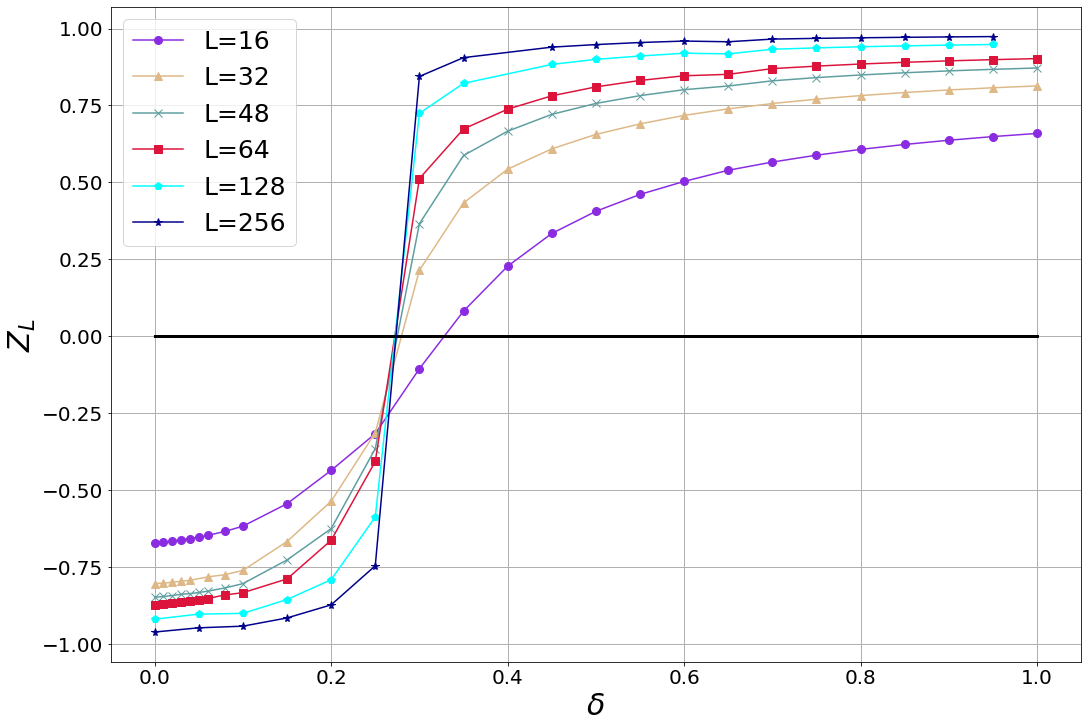

In [30]:
# 固定J, 看L, Order parameter 對 D 的圖(橫切)

OrderPara = "ZL"                
# Ls = [16,24,32,40,48,56,64]         ## Choose size 
Ls = [16,32,48,64,128,256]       
Dimer = ALL_Dimer
Jdis = ["Jdis000"]

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(15,10))

Para = "ZL"
ylable = r'$Z_L$'
    
for l in range(len(Ls)):
    L = Ls[l]

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['Dimer', Para, 'error'])    

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            myfile = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): ## Some data is not ok, so we need to ignore it.
                continue

            df = pd.read_csv(myfile)

            if (OrderPara == "SOP"):
                mean = {'Dimer':D, Para:-1*df[Para][0], 'error':df["error"][0]}    
            else:
                mean = {'Dimer':D, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[d] = mean

        ax.plot(dfplt['Dimer'], dfplt[Para]*0, "-", color='black', linewidth = 3)
        ax.plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[l], markersize = 8, label = 'L=%d' %(L))
        # ax.errorbar(dfplt['Dimer'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=15, capthick=2, color=carr[l], label=None)
        ax.set_xlabel(r'$\delta$', fontsize=30)
        ax.set_ylabel(ylable, fontsize=30)
        ax.tick_params(axis='x', labelsize=20) 
        ax.tick_params(axis='y', labelsize=20)
        # ax.set_title("Jdis = %.2f" %(J), fontsize=30)
        ax.grid(linestyle='-', linewidth=1)
        # ax.set_xlim([0, 1])
        # ax.set_ylim([-1, 1])
        # ax.set_xlim([0., 0.2])
        # ax.set_ylim([-0.35, 0.])
        ax.legend(loc = 'best',fontsize=25)
            
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=30)
# fig.legend(lines, labels, fontsize=30)
plt.savefig('../tSDRG_figure/'+ OrderPara +'/Spin'+ str(spin) +'/Spin'+ str(spin) +'_'+ OrderPara +'_D-'+ jdis +'.pdf', format='pdf')
plt.show() 

## Fix **<font color = yellow>J</font>**, look **<font color = red>L</font>**, **ZL** vs **<font color = green>D</font>**, Multiplot 

### **<font color = yellow>J</font>** = 0 ~ 0.7

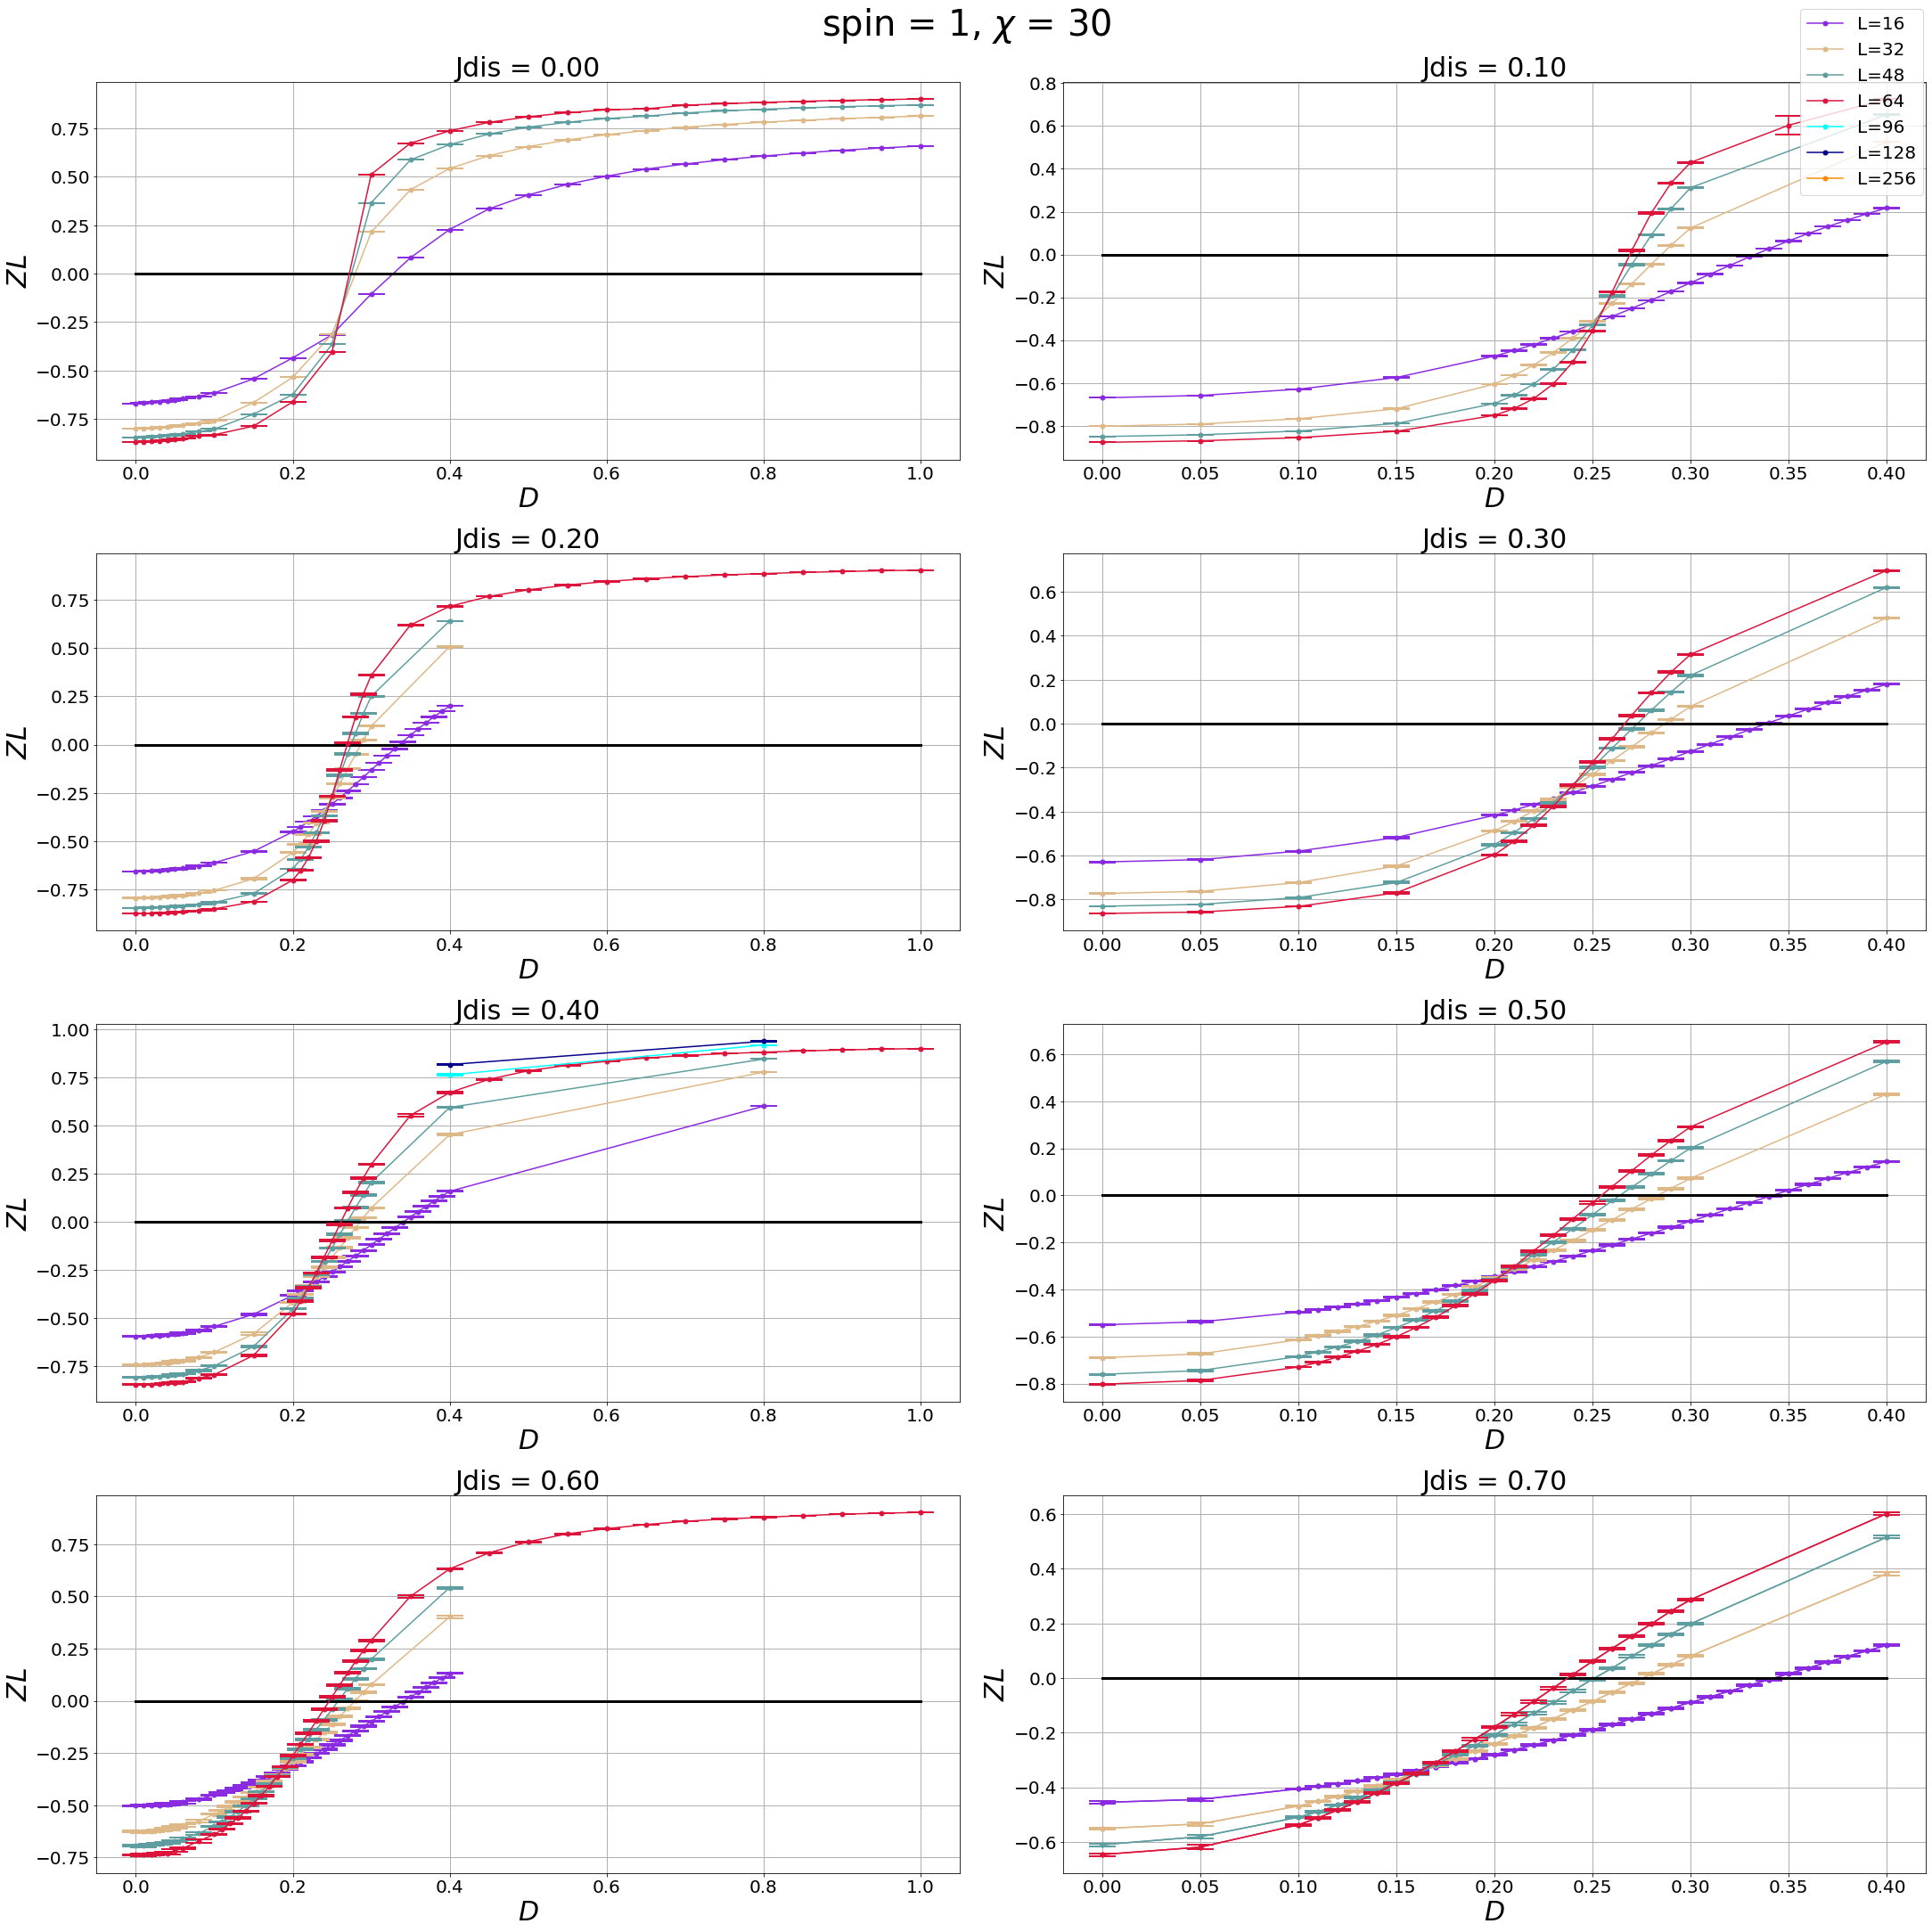

In [10]:
# 固定J, 看L, ZL 對 D 的圖(橫切)

OrderPara = "ZL"                ## Choose SOP or ZL
# Ls = [16,24,32,40,48,56,64,72,80,88,96,128,256]             ## Choose size 
Ls = [16,32,48,64,96,128,256]    
Dimer = ALL_Dimer
Jdis = ["Jdis000","Jdis010","Jdis020","Jdis030","Jdis040","Jdis050","Jdis060","Jdis070"]
# Jdis = ["Jdis040","Jdis050","Jdis060","Jdis070","Jdis072","Jdis075","Jdis078","Jdis080"]
# fig, ax = plt.subplots(4, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,30)) ## fix same x, y axis
fig, ax = plt.subplots(4, 2, constrained_layout=True, figsize=(30,30))

Para = "ZL"
ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['Dimer', Para, 'error'])    

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            myfile = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): ## Some data is not ok, so we need to ignore it.
                continue

            df = pd.read_csv(myfile)

            if (OrderPara == "SOP" and spin == 2):
                mean = {'Dimer':D, Para:-1*df[Para][0], 'error':df["error"][0]}    
            else:
                mean = {'Dimer':D, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[d] = mean

        if (j == len(Jdis)-1):
           ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], "o-", color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para]*0, "-", color='black', linewidth = 3)
        ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], "o-", color=carr[l], markersize = 5)
        ax[int(j/2)][j-2*int(j/2)].errorbar(dfplt['Dimer'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=15, capthick=2, color=carr[l], label=None)
        ax[int(j/2)][j-2*int(j/2)].set_xlabel(r'$D$', fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].set_ylabel(ylable, fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='x', labelsize=20) 
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='y', labelsize=20)
        ax[int(j/2)][j-2*int(j/2)].set_title("Jdis = %.2f" %(J), fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].grid(linestyle='-', linewidth=1)

        # ax[int(j/2)][j-2*int(j/2)].set_xlim([0, 0.4])
        # ax[int(j/2)][j-2*int(j/2)].set_ylim([-0.5, 0.4])
        # ax[int(j/2)][j-2*int(j/2)].legend(loc = 'best',fontsize=10)
            
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=20)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show() 

### **<font color = yellow>J</font>** = 0.8 ~ 1.05

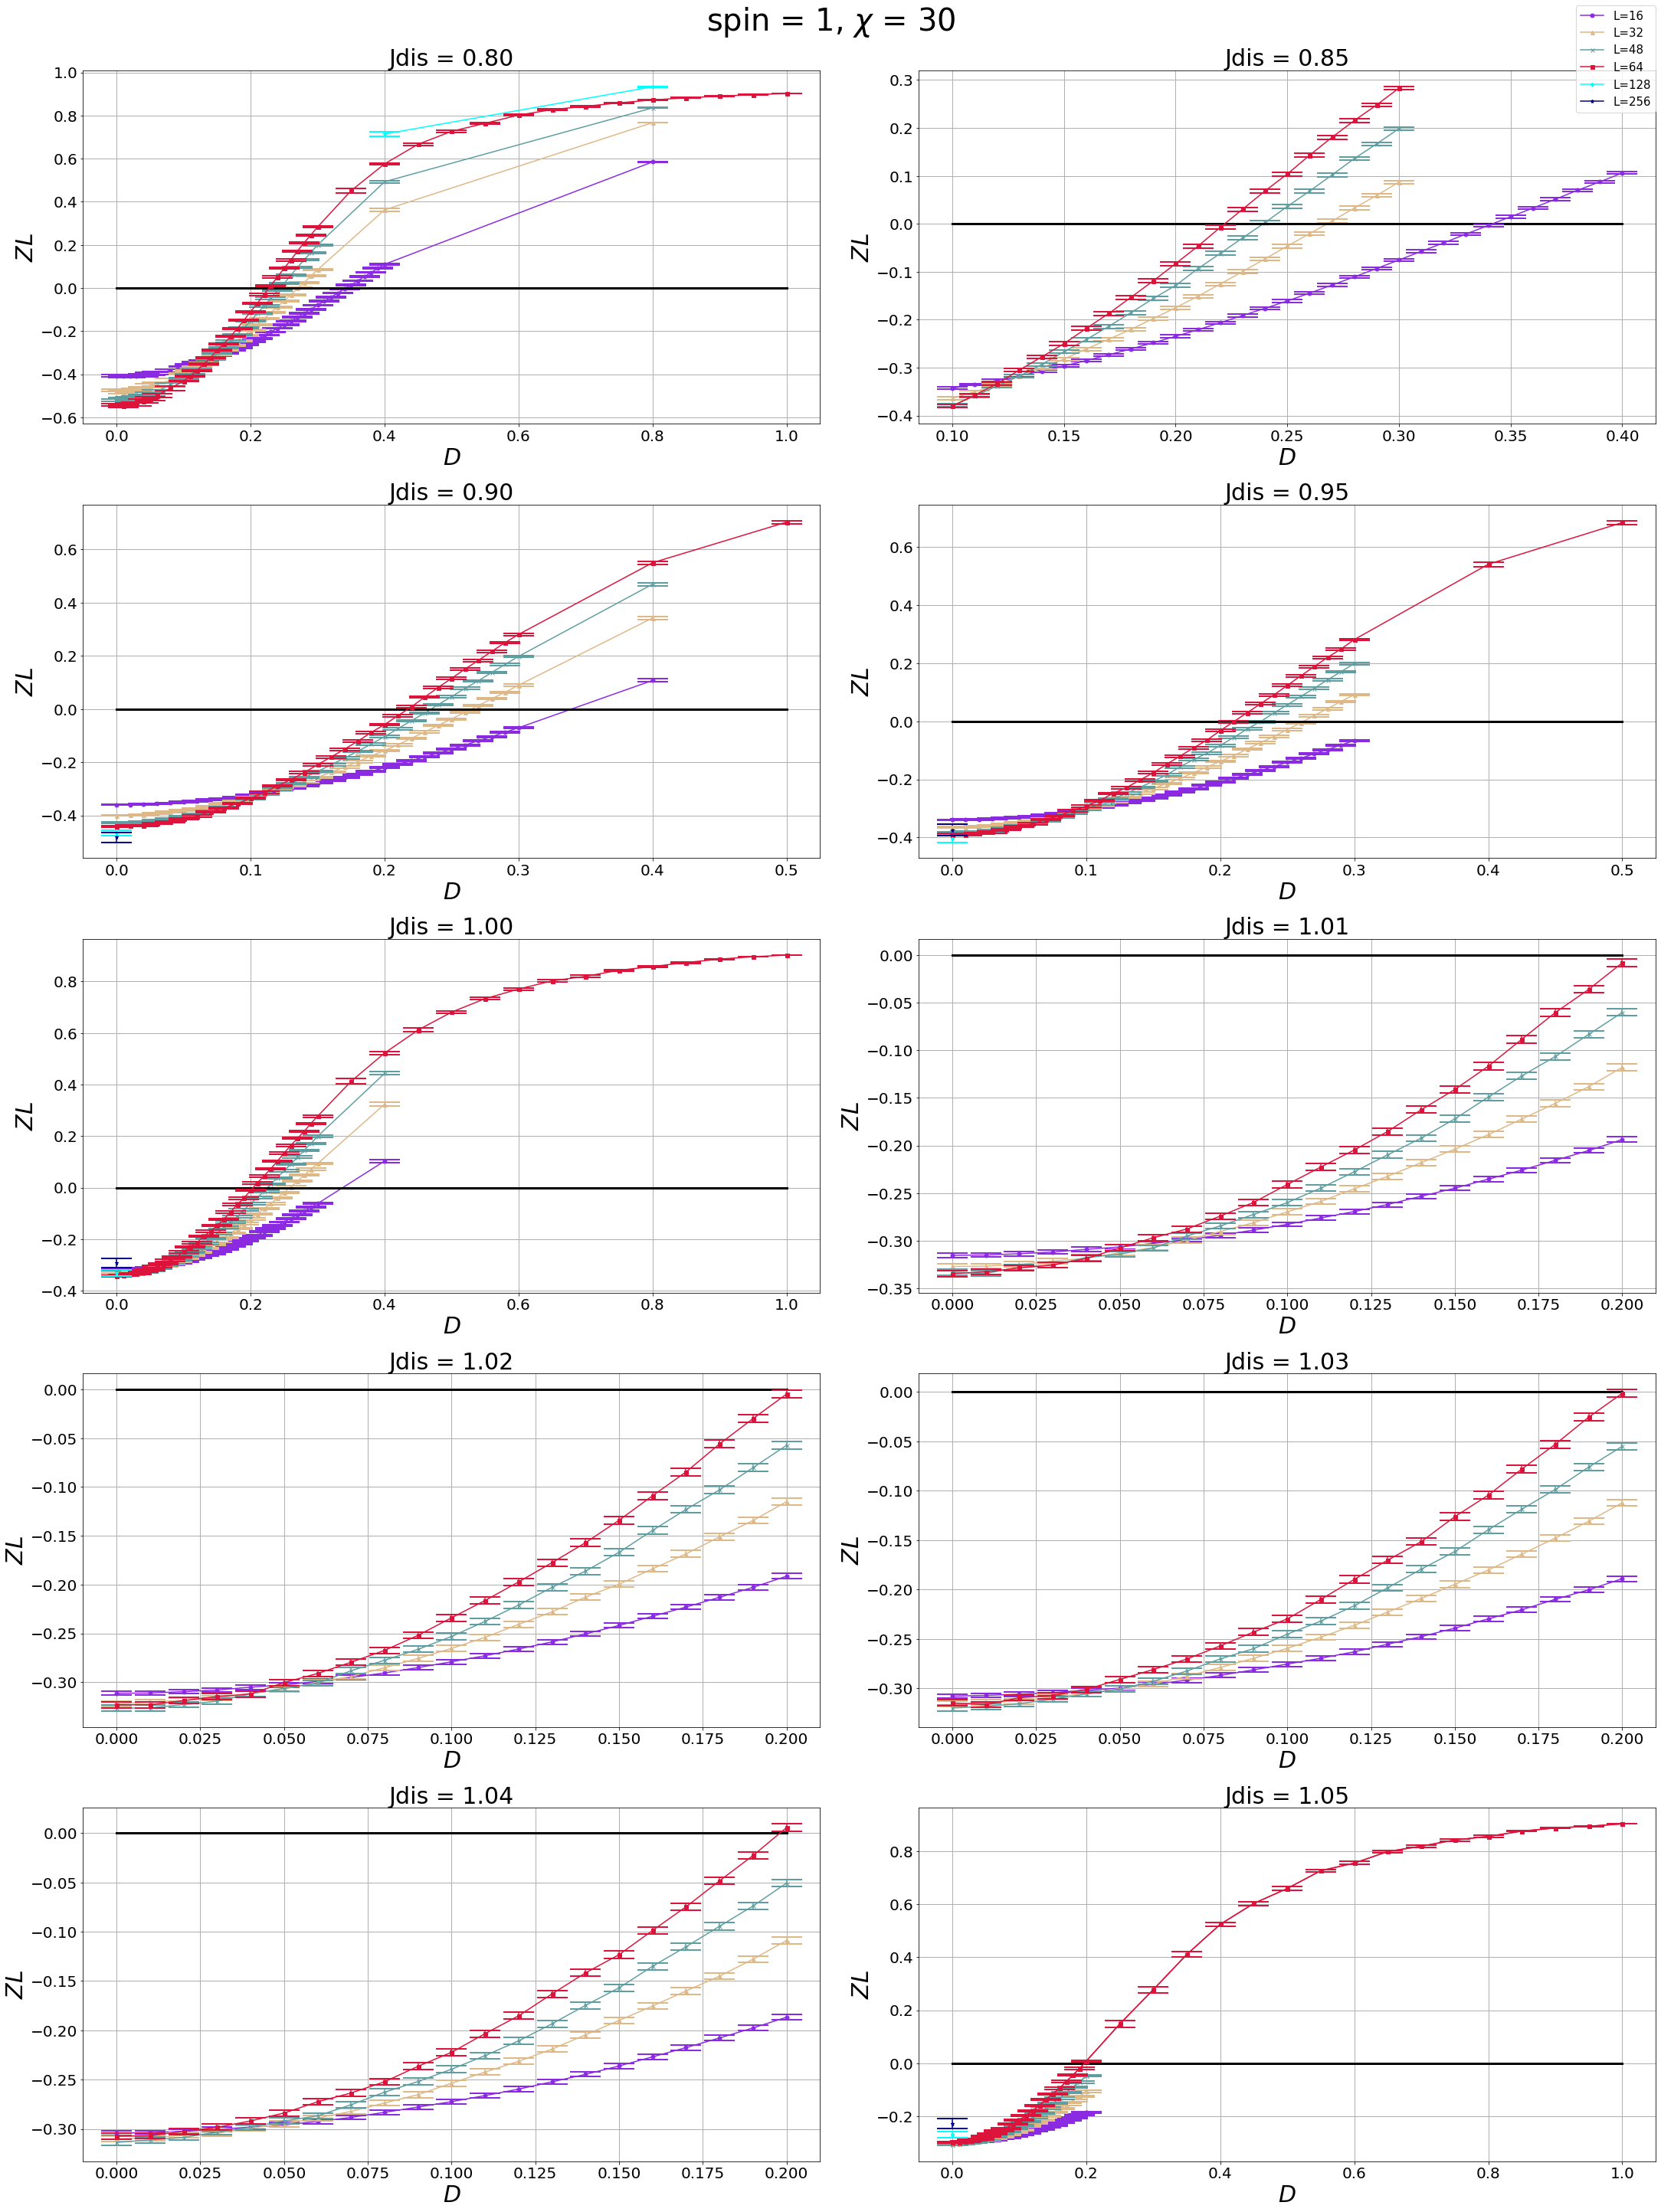

In [12]:
# 固定J, 看L, ZL 對 D 的圖(橫切)

OrderPara = "ZL"                ## Choose SOP or ZL
Ls = [16,32,48,64,128,256]              ## Choose size 
Dimer = ALL_Dimer
Jdis = ["Jdis080","Jdis085","Jdis090","Jdis095","Jdis100","Jdis101","Jdis102","Jdis103","Jdis104","Jdis105"]

# fig, ax = plt.subplots(4, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,30)) ## fix same x, y axis
fig, ax = plt.subplots(5, 2, constrained_layout=True, figsize=(30,40))

Para = "ZL"
ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['Dimer', Para, 'error'])    

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            myfile = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): ## Some data is not ok, so we need to ignore it.
                continue

            df = pd.read_csv(myfile)

            mean = {'Dimer':D, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[d] = mean

        if (j == len(Jdis)-1):
           ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], marr[l%7], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para]*0, "-", color='black', linewidth = 3)
        ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], marr[l%7], color=carr[l], markersize = 5)
        ax[int(j/2)][j-2*int(j/2)].errorbar(dfplt['Dimer'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(j/2)][j-2*int(j/2)].set_xlabel(r'$D$', fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].set_ylabel(ylable, fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='x', labelsize=20) 
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='y', labelsize=20)
        ax[int(j/2)][j-2*int(j/2)].set_title("Jdis = %.2f" %(J), fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].grid(linestyle='-', linewidth=1)
        # ax[int(j/2)][j-2*int(j/2)].set_xlim([0, 0.7])
        # ax[int(j/2)][j-2*int(j/2)].set_ylim([-0.15, 0.2])
        # ax[int(j/2)][j-2*int(j/2)].legend(loc = 'best',fontsize=10)
            
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show()

## 線性 fitting $D_c$(L_diff=0) vs 1/**<font color = red>L</font>**

In [45]:
PhaseDiagram_D1 = pd.DataFrame(columns = ['J', 'D1'])

J = 0.00, L -> oo, D* = 0.2550
J = 0.20, L -> oo, D* = 0.2553
J = 0.40, L -> oo, D* = 0.2273
J = 0.60, L -> oo, D* = 0.1834
J = 0.80, L -> oo, D* = 0.1231
J = 0.90, L -> oo, D* = 0.0847


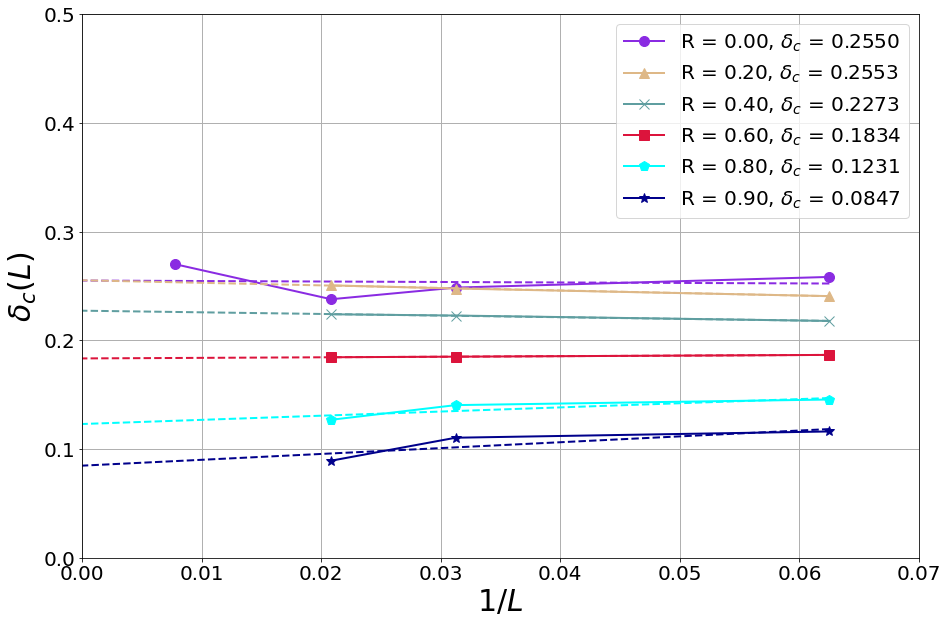

In [57]:
## First crossing point D1
power = 1
OrderPara = "ZL"
Para = "ZL"

# Ls = [16,24,32,40,48,56,64]
Ls = [16,32,48,64]  
# Jdis = ["Jdis000","Jdis010","Jdis020","Jdis030","Jdis040","Jdis050","Jdis060","Jdis070","Jdis080","Jdis090","Jdis100"]
Jdis = ["Jdis000","Jdis020","Jdis040","Jdis060","Jdis080","Jdis090"]
# Jdis = ["Jdis000"]
Dimer = ALL_Dimer[0:40]
n_point = 4

for j in range(len(Jdis)):
    jdis = Jdis[j]
    J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
    D1s = []
    x = []
    if (J == 0):
        Ls = [16,32,48,64,96,128,256] 
    else:
        Ls = [16,32,48,64] 

    for l in range(len(Ls)-1):
        skip_L = False
        L1 = Ls[l]
        L2 = Ls[l+1]
        f_L1 = pd.DataFrame(columns = ['Dimer', 'ZL'])
        f_L2 = pd.DataFrame(columns = ['Dimer', 'ZL'])
        f_diff = pd.DataFrame(columns = ['Dimer', 'diff'])
        ignore_num = 0
        # print(L1)

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            file_L1 = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L1) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'
            file_L2 = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L2) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'
        
            if (os.path.exists(file_L1) == False or os.path.exists(file_L2) == False): # Some data is not ok, so we need to ignore it.
                ignore_num += 1
                continue
        
            df_L1 = pd.read_csv(file_L1)
            df_L2 = pd.read_csv(file_L2)

            mean_L1 = {'Dimer':D, 'ZL':df_L1[Para][0]}
            mean_L2 = {'Dimer':D, 'ZL':df_L2[Para][0]}
            mean_diff = {'Dimer':D, 'diff':df_L2[Para][0]-df_L1[Para][0]}

            f_L1.loc[d-ignore_num] = mean_L1
            f_L2.loc[d-ignore_num] = mean_L2
            f_diff.loc[d-ignore_num] = mean_diff

        ids, skip_L = find_id(f_diff, skip_L)
        # print(ids)
        if (skip_L):
            continue

        D1 = fitting_point(f_L1, f_L2, ids, "Dimer", Para, n_point)
        D1s.append(D1)
        x.append(L1**-1)

    x.append(0)
    p = np.polyfit(x[:-1], D1s, power)
    f = np.polyval(p,x)

    print('J = %.2f, L -> oo, D* = %.4f' %(J, p[power]))
    plt.plot(x[:-1], D1s, marr[j%6], markersize = font_size/3, color = carr[j], linewidth = font_size/15, label = 'R = %.2f, $\delta_c$ = %.4f' %(J, p[power]))
    plt.plot(x, f, '--', markersize = font_size/3, color = carr[j], linewidth = font_size/15)

    mean_D = {'J':J, 'D1':p[power]}
    PhaseDiagram_D1.loc[j] = mean_D

# plt.xscale('log')
# plt.yscale('log')
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.ylabel(r'$\delta_c(L)$', fontsize=font_size)
plt.xlabel(r'$1/L$', fontsize=font_size)
plt.xlim(0, 0.07)
plt.ylim(0, 0.5)
plt.grid(linestyle='-', linewidth=1)
# plt.title('linear fit, first point D1, spin = %s, $\chi$ = %d' % (spin, M), fontsize=font_size)
# plt.legend(bbox_to_anchor=(1, 1), loc = 'best',fontsize=font_size*4/6)
plt.legend(loc = 'best',fontsize=font_size*4/6)
fig = plt.gcf()
fig.set_size_inches(15, 10)
if (len(Jdis) == 1):
    plt.savefig('../tSDRG_figure/'+ OrderPara +'/Spin'+ str(spin) +'/Spin'+ str(spin) +'_'+ OrderPara +'_CrossFit_D-'+ jdis +'.pdf', format='pdf')
else:
    plt.savefig('../tSDRG_figure/'+ OrderPara +'/Spin'+ str(spin) +'/Spin'+ str(spin) +'_'+ OrderPara +'_CrossFit_D.pdf', format='pdf')
plt.show()

## 二次式 fitting $D_c$(L_diff=0) vs 1/**<font color = red>L</font>**

In [37]:
PhaseDiagram_D1_2 = pd.DataFrame(columns = ['J', 'D1'])

J = 0.10, L -> oo, D* = 0.1698
J = 0.50, L -> oo, D* = 0.1140


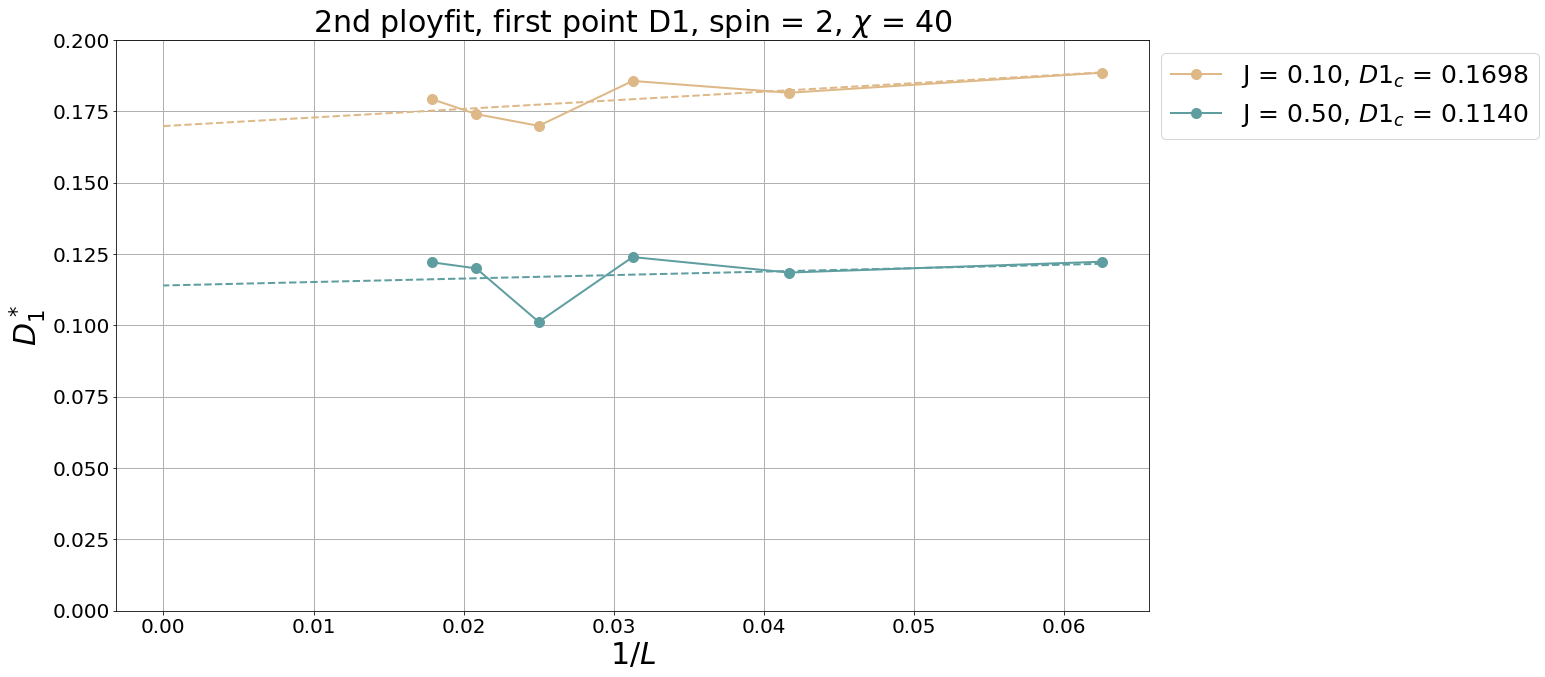

In [38]:
## First crossing point D1 (用二次式fitting)
power = 1
OrderPara = "ZL"
Para = "ZL"
plt.ylabel(r'$ZL$_diff', fontsize=font_size)

N = 10000
Ls = [16,24,32,40,48,56,64]
Jdis = ["Jdis010","Jdis050"]
Dimer = ALL_Dimer[0:30]
L_n_point = 1
R_n_point = 2

for j in range(len(Jdis)):
    jdis = Jdis[j]
    J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
    D1s = []
    x = []

    for l in range(len(Ls)-1):
        skip_L = False
        L1 = Ls[l]
        L2 = Ls[l+1]
        f_L1 = pd.DataFrame(columns = ['Dimer', 'ZL'])
        f_L2 = pd.DataFrame(columns = ['Dimer', 'ZL'])
        f_diff = pd.DataFrame(columns = ['Dimer', 'diff'])
        ignore_num = 0
        # print(L1)

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        
            file_L1 = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L1) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'
            file_L2 = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L2) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'
            
            if (os.path.exists(file_L1) == False or os.path.exists(file_L2) == False): # Some data is not ok, so we need to ignore it.
                ignore_num += 1
                continue
        
            df_L1 = pd.read_csv(file_L1)
            df_L2 = pd.read_csv(file_L2)

            mean_L1 = {'Dimer':D, 'ZL':df_L1[Para][0]}
            mean_L2 = {'Dimer':D, 'ZL':df_L2[Para][0]}
            mean_diff = {'Dimer':D, 'diff':df_L2[Para][0]-df_L1[Para][0]}

            f_L1.loc[d-ignore_num] = mean_L1
            f_L2.loc[d-ignore_num] = mean_L2
            f_diff.loc[d-ignore_num] = mean_diff

        ids, skip_L = find_id(f_diff, skip_L)

        if (skip_L):
            # print(L1)
            continue

        x1,x2 = fitting_point_second(f_L1, f_L2, ids, "Dimer", Para, L_n_point, R_n_point)
        D1s.append(x1)
        x.append(L1**-1)

    x.append(0)
    p = np.polyfit(x[:-1], D1s, power)
    f = np.polyval(p,x)
    
    print('J = %.2f, L -> oo, D* = %.4f' %(J, p[power]))
    plt.plot(x[:-1], D1s, 'o-', markersize = font_size/3, color = carr[j], linewidth = font_size/15, label = 'J = %.2f, $D1_c$ = %.4f' %(J, p[power]))
    plt.plot(x, f, '--', markersize = font_size/3, color = carr[j], linewidth = font_size/15)

    mean_D = {'J':J, 'D1':p[power]}
    PhaseDiagram_D1_2.loc[j] = mean_D

# plt.xscale('log')
# plt.yscale('log')
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.ylabel(r'$D_1^*$', fontsize=font_size)
plt.xlabel(r'$1/L$', fontsize=font_size)
# plt.xlim(0, 0.07)
plt.ylim(0, 0.2)
plt.grid(linestyle='-', linewidth=1)
plt.title('2nd ployfit, first point D1, spin = %s, $\chi$ = %d' % (spin, M), fontsize=font_size)
plt.legend(bbox_to_anchor=(1, 1), loc = 'best',fontsize=font_size*5/6)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.show()

## 線性 fitting $D_c$(L_diff=0) vs 1/**<font color = red>L</font>**$^{\nu}$

In [40]:
PhaseDiagram_D1_nu = pd.DataFrame(columns = ['J', 'D1'])

def func(x, a, b, c):
    return a * x**b + c

J = 0.10, L -> oo, D* = 0.1701


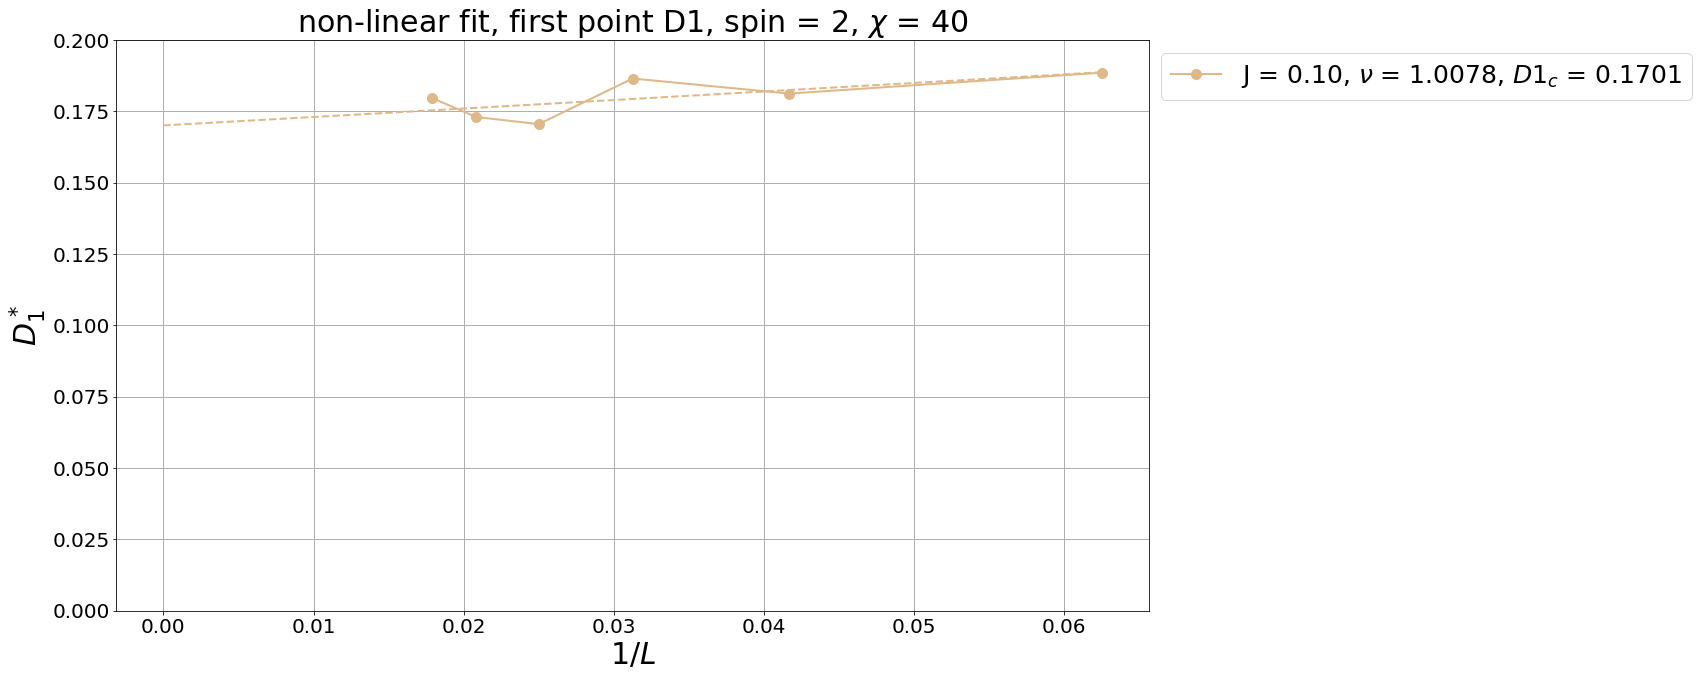

In [18]:
## First crossing point D1

OrderPara = "ZL"
Para = "ZL"

N = 10000
Ls = [16,24,32,40,48,56,64]
# Jdis = ["Jdis010","Jdis020","Jdis030","Jdis040","Jdis050","Jdis060","Jdis070"]
Jdis = ["Jdis010"]
Dimer = ALL_Dimer[14:22]
n_point = 4

for j in range(len(Jdis)):
    jdis = Jdis[j]
    J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
    D1s = []
    x = []

    for l in range(len(Ls)-1):
        skip_L = False
        L1 = Ls[l]
        L2 = Ls[l+1]
        f_L1 = pd.DataFrame(columns = ['Dimer', 'ZL'])
        f_L2 = pd.DataFrame(columns = ['Dimer', 'ZL'])
        f_diff = pd.DataFrame(columns = ['Dimer', 'diff'])
        ignore_num = 0
        # print(L1)

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        
            file_L1 = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L1) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'
            file_L2 = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L2) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'
            
            if (os.path.exists(file_L1) == False or os.path.exists(file_L2) == False): # Some data is not ok, so we need to ignore it.
                ignore_num += 1
                continue
        
            df_L1 = pd.read_csv(file_L1)
            df_L2 = pd.read_csv(file_L2)

            mean_L1 = {'Dimer':D, 'ZL':df_L1[Para][0]}
            mean_L2 = {'Dimer':D, 'ZL':df_L2[Para][0]}
            mean_diff = {'Dimer':D, 'diff':df_L2[Para][0]-df_L1[Para][0]}

            f_L1.loc[d-ignore_num] = mean_L1
            f_L2.loc[d-ignore_num] = mean_L2
            f_diff.loc[d-ignore_num] = mean_diff

        ids, skip_L = find_id(f_diff, skip_L)
        # print(ids)
        if (skip_L):
            continue

        D1 = fitting_point(f_L1, f_L2, ids, "Dimer", Para, n_point)
        D1s.append(D1)
        x.append(L1**-1)

    x.append(0)
    # popt, pcov = curve_fit(func, x[:-1], D1s, maxfev=10000, bounds = (0, (np.inf,np.inf,np.inf)))
    popt, pcov = curve_fit(func, x[:-1], D1s, maxfev=100000)

    # print(x)
    # print(D1s)
    # print(popt)

    print('J = %.2f, L -> oo, D* = %.4f' %(J, popt[2]))
    plt.plot(x[:-1], D1s, 'o-', markersize = font_size/3, color = carr[j], linewidth = font_size/15, label = r'J = %.2f, ${\nu}$ = %.4f, $D1_c$ = %.4f' %(J, popt[1], popt[2]))
    plt.plot(x, func(x, *popt), '--', markersize = font_size/3, color = carr[j], linewidth = font_size/15)

    mean_D = {'J':J, 'D1':popt[2]}
    PhaseDiagram_D1_nu.loc[j] = mean_D

# plt.xscale('log')
# plt.yscale('log')
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.ylabel(r'$D_1^*$', fontsize=font_size)
plt.xlabel(r'$1/L$', fontsize=font_size)
# plt.xlim(0, 0.07)
plt.ylim(0, 0.2)
plt.grid(linestyle='-', linewidth=1)
plt.title('non-linear fit, first point D1, spin = %s, $\chi$ = %d' % (spin, M), fontsize=font_size)
plt.legend(bbox_to_anchor=(1, 1), loc = 'best',fontsize=font_size*5/6)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.show()

## fitting $D_c$(ZL=0) vs 1/**<font color = red>L</font>**$^2$

In [47]:
PhaseDiagram_D1_zl = pd.DataFrame(columns = ['J', 'D1'])

In [2]:
## fitting D_c(L) vs 1/L^2 (第一交點)

OrderPara = "ZL"
Para = "ZL"

# Ls = [16,24,32,40,48,56,64]
Ls = [16,32,48,64]  
# Jdis = ["Jdis000","Jdis010","Jdis020","Jdis030","Jdis040","Jdis050","Jdis060","Jdis070","Jdis080","Jdis090","Jdis100"]
Jdis = ["Jdis000","Jdis020","Jdis040","Jdis060","Jdis080","Jdis090"]
# Jdis = ["Jdis000"]
Dimer = ALL_Dimer[0:50]
n_point = 4

for j in range(len(Jdis)):
    jdis = Jdis[j]
    J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
    D1 = []
    x = []

    if (J >= 1):
        Ls = [16,32,48,64]

    for l in range(len(Ls)):
        skip_L = False
        L = Ls[l]
        f_L = pd.DataFrame(columns = ['Dimer', 'ZL'])
        ignore_num = 0
        # print(L)
        if (J == 2 and L == 64):
            Dimer = ALL_Dimer[0:45]

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            file_L = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'
            
            if (os.path.exists(file_L) == False): # Some data is not ok, so we need to ignore it.
                ignore_num += 1
                continue
            df_L = pd.read_csv(file_L)

            mean_L = {'Dimer':D, 'ZL':df_L[Para][0]}

            f_L.loc[d-ignore_num] = mean_L

        # print(str(L)+' ')
        ids, skip_L = find_id_2(f_L, skip_L)

        if (skip_L):
            continue
        x1 = fitting_point_2(f_L, ids, "Dimer", Para, n_point)
        D1.append(x1)
        x.append(L**-2)

    if (len(D1) < 2):
        continue

    # print(D1)
    x.append(0)
    p = np.polyfit(x[:-1], D1, 3)
    f = np.polyval(p,x)
    print('R = %.2f, L -> oo, $\delta_c$ = %.4f' %(J, p[3]))
    plt.plot(x, f, "--", markersize = font_size/3, color = carr[j], linewidth = font_size/15)
    plt.plot(x[:-1], D1, marr[j%6], markersize = font_size/3, color = carr[j], linewidth = font_size/15, label = 'R = %.2f, $\delta_c$ = %.4f' %(J, p[3]))

    mean_D = {'J':J, 'D1':p[3]}
    PhaseDiagram_D1_zl.loc[j] = mean_D

# plt.xscale('log')
# plt.yscale('log')
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.ylabel(r'$\delta_c(L)$', fontsize=font_size)
plt.xlabel(r'$1/L^2$', fontsize=font_size)
# plt.xlim(0, 0.07)
# plt.ylim(0.22, 0.3)
plt.grid(linestyle='-', linewidth=1)
# plt.title('spin = %s, $\chi$ = %d, first point' % (spin, M), fontsize=font_size)
# plt.legend(bbox_to_anchor=(1, 1), loc = 'best',fontsize=font_size*5/6)
plt.legend(loc = 'best',fontsize=font_size*4/6)
fig = plt.gcf()  
fig.set_size_inches(15, 10)
if (len(Jdis) == 1):
    plt.savefig('../tSDRG_figure/'+ OrderPara +'/Spin'+ str(spin) +'/Spin'+ str(spin) +'_'+ OrderPara +'_CrossFit2_D-'+ jdis +'.pdf', format='pdf')
else:
    plt.savefig('../tSDRG_figure/'+ OrderPara +'/Spin'+ str(spin) +'/Spin'+ str(spin) +'_'+ OrderPara +'_CrossFit2_D.pdf', format='pdf')
plt.show()

NameError: name 'ALL_Dimer' is not defined

## Phase Diagram

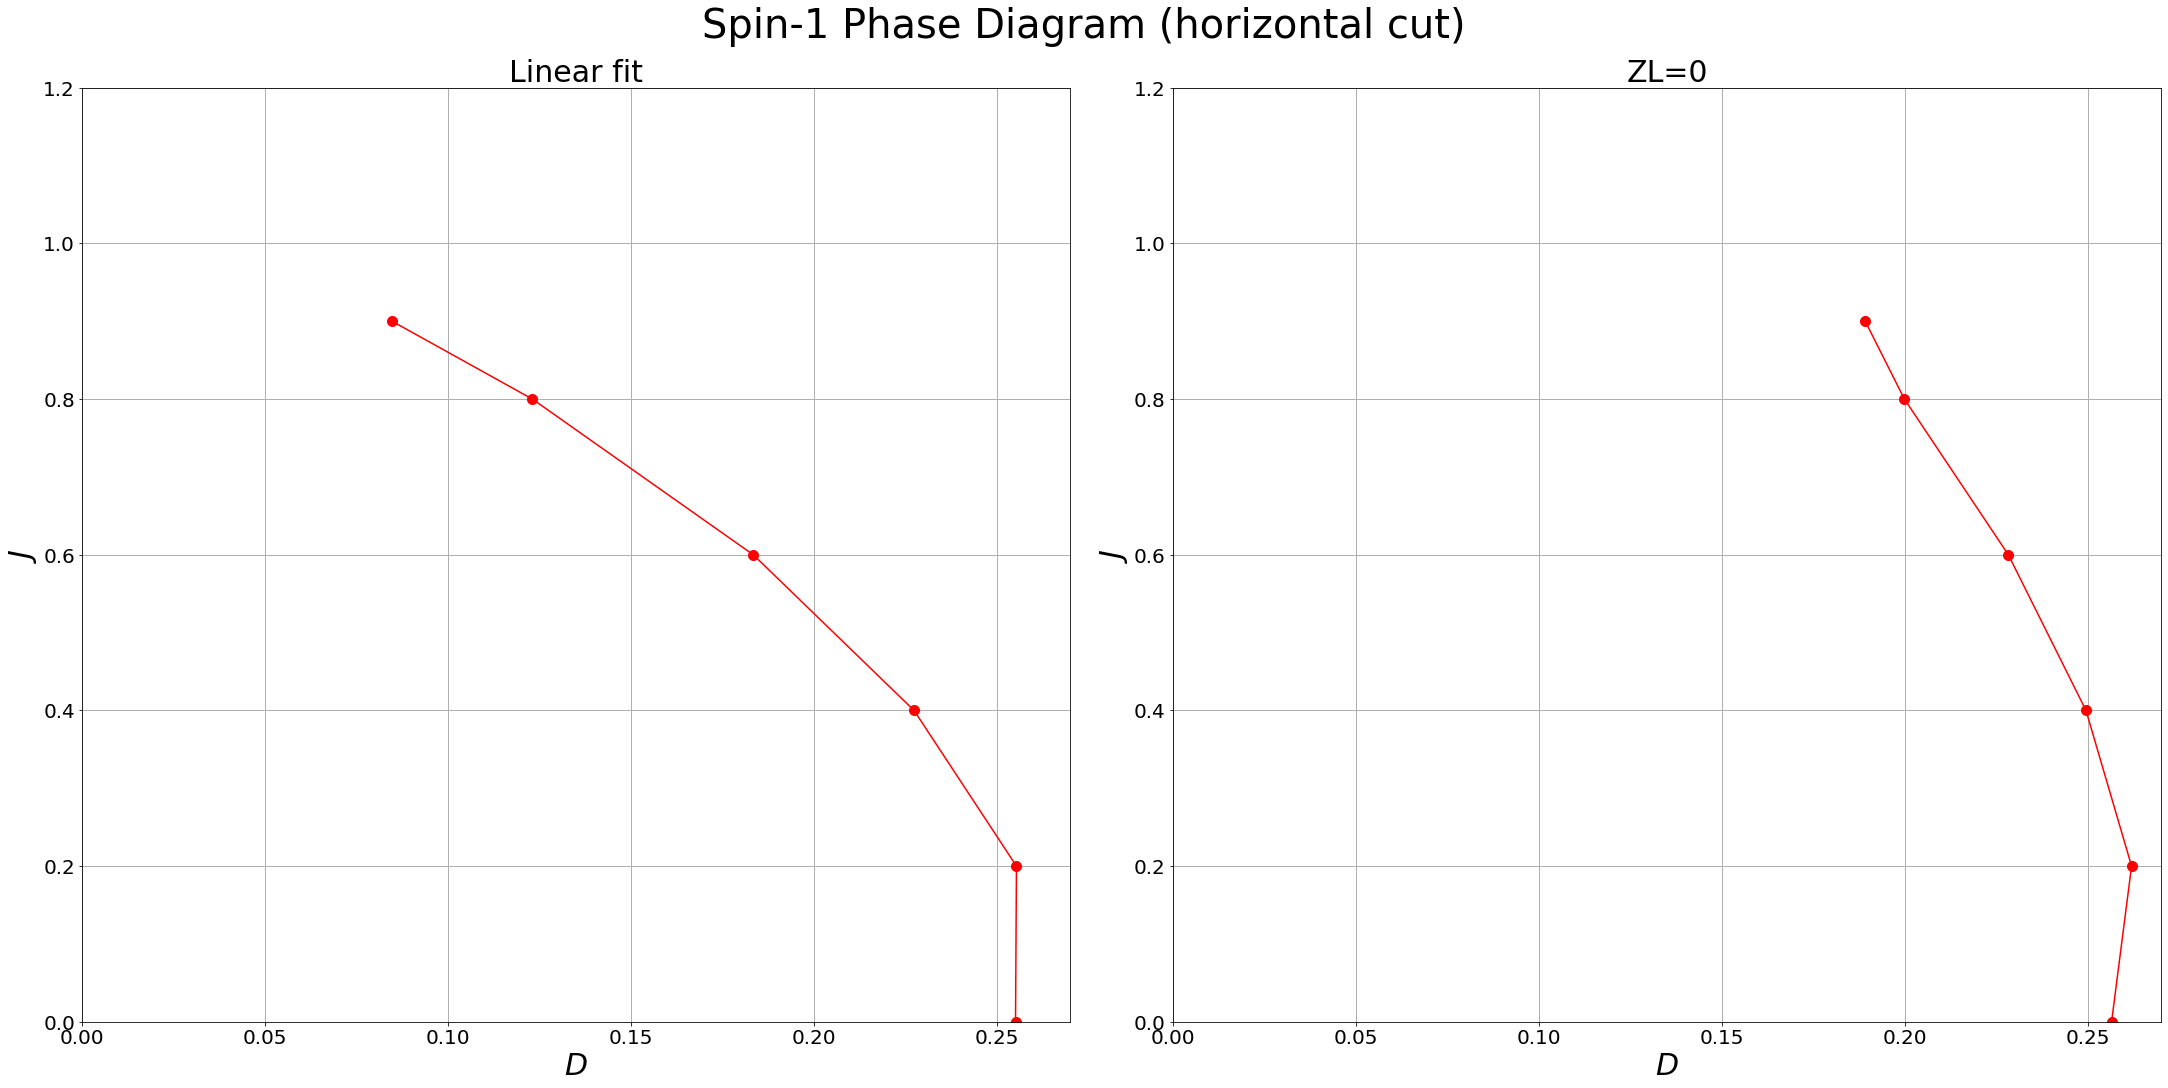

In [60]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(30,15))
## linear fit
ax[0].plot(PhaseDiagram_D1['D1'], PhaseDiagram_D1['J'], '-o', color="red", markersize = font_size/3)
ax[0].set_xlabel(r'$D$', fontsize=30)
ax[0].set_ylabel(r'$J$', fontsize=30)
ax[0].tick_params(axis='x', labelsize=20) 
ax[0].tick_params(axis='y', labelsize=20)
ax[0].set_title('Linear fit', fontsize=30)
ax[0].grid(linestyle='-', linewidth=1)
ax[0].set_xlim([0, 0.27])                  
ax[0].set_ylim([0, 1.2])          
# ax[0].legend(loc = 'best',fontsize=font_size*5/6)

## 2nd polynomial fit
# ax[1].plot(PhaseDiagram_D1_2['D1'], PhaseDiagram_D1_2['J'], '-o', color="red", markersize = font_size/3)
# ax[1].set_xlabel(r'$D$', fontsize=30)
# ax[1].set_ylabel(r'$J$', fontsize=30)
# ax[1].tick_params(axis='x', labelsize=20) 
# ax[1].tick_params(axis='y', labelsize=20)
# ax[1].set_title('2nd polynomial fit', fontsize=30)
# ax[1].grid(linestyle='-', linewidth=1)
# ax[1].set_xlim([0, 0.6])                  
# ax[1].set_ylim([0, 2.6])          
# ax[1].legend(loc = 'best',fontsize=font_size*5/6)

# ## nonlinear fit
# ax[2].plot(PhaseDiagram_D1_nu['D1'], PhaseDiagram_D1_nu['J'], '-o', color="red", markersize = font_size/3)
# ax[2].set_xlabel(r'$D$', fontsize=30)
# ax[2].set_ylabel(r'$J$', fontsize=30)
# ax[2].tick_params(axis='x', labelsize=20) 
# ax[2].tick_params(axis='y', labelsize=20)
# ax[2].set_title('Nonlinear fit', fontsize=30)
# ax[2].grid(linestyle='-', linewidth=1)
# ax[2].set_xlim([0, 0.6])                   
# ax[2].set_ylim([0, 2.6])          
# # ax[2].legend(loc = 'best',fontsize=font_size*5/6)

## ZL=0 fit
ax[1].plot(PhaseDiagram_D1_zl['D1'], PhaseDiagram_D1_zl['J'], '-o', color="red", markersize = font_size/3)
ax[1].set_xlabel(r'$D$', fontsize=30)
ax[1].set_ylabel(r'$J$', fontsize=30)
ax[1].tick_params(axis='x', labelsize=20) 
ax[1].tick_params(axis='y', labelsize=20)
ax[1].set_title('ZL=0', fontsize=30)
ax[1].grid(linestyle='-', linewidth=1)
ax[1].set_xlim([0, 0.27])                  
ax[1].set_ylim([0, 1.2])           
# ax[1].legend(loc = 'best',fontsize=font_size*5/6)

fig.suptitle('Spin-'+ str(spin) +' Phase Diagram (horizontal cut)', fontsize=40)

PhaseDiagram_D1.to_csv('./HPD.csv', index=0)
PhaseDiagram_D1_zl.to_csv('./HPD_zl.csv', index=0)